# create_ground_truth

In [99]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.sparse.linalg import eigs

# __all__ = ['create_ground_truth']

def compute_Lk_and_lambdak(L, K, separated=False):
    lambdas, _ = eigs(L)
    lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
    lambda_max = np.max(lambdas).real
    lambda_min = np.min(lambdas).real
    Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
    # for the "separated" implementation we need a different dimensionality
    if separated:
        lambda_max_k = lambda_max ** np.arange(1, K + 1)
        lambda_min_k = lambda_min ** np.arange(1, K + 1)
    else:
        lambda_max_k = lambda_max ** np.array(list(np.arange(1, K + 1))+[0])
        lambda_min_k = lambda_min ** np.array(list(np.arange(1, K + 1))+[0])
    return Lk, lambda_max_k, lambda_min_k

def generate_coeffs(*arrays, s, mult=10):
    """ 
    Select ad hoc parameters for synthetic data generation, randomly over
    an interval dependent on the max eigenvalues of the Laplacian(s)
    """

    # if passing four arguments (two for upper and two for lower laplacian eigevals)
    # it means that you are using dictionary_type="separated"
    if len(arrays)==2:
        lambda_max_k, lambda_min_k = arrays
        K = lambda_max_k.shape[0]
        h = mult / np.max(lambda_max_k) * np.random.rand(s, K)
        # For later sanity check in optimization phase 
        tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
        tmp_min_vec = h @ lambda_min_k
        c = np.max(tmp_max_vec)
        tmp_sum_max = np.sum(tmp_max_vec)
        tmp_sum_min = np.sum(tmp_min_vec)

        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

    elif len(arrays)==4:
        lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k = arrays
        K = lambda_max_u_k.shape[0]
        hI = mult / np.max(lambda_max_d_k) * np.random.rand(s, K)
        hS = mult / np.max(lambda_max_u_k) * np.random.rand(s, K)
        hH = mult / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
        h = [hS, hI, hH]
        # For later sanity check in optimization phase
        tmp_max_vec_S = (hS @ lambda_max_u_k).reshape(s,1)
        tmp_min_vec_S = (hS @ lambda_min_u_k).reshape(s,1)
        tmp_max_vec_I = (hI @ lambda_max_d_k).reshape(s,1)
        tmp_min_vec_I = (hI @ lambda_min_d_k).reshape(s,1)
        c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
        tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
        tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = np.max([Delta_min, Delta_max])
    else:
        raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
                        the first 2 refer to upper laplacian and the other two to lower laplacian.")
    return h, c, epsilon, tmp_sum_min, tmp_sum_max

def generate_dictionary(h, s, *matrices):
    D = []
    # Always check if upper and lower Laplacians are separately provided
    if len(matrices)==1:
        Lk = matrices[0]
        n = Lk.shape[-1]
        k = Lk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            h_tmp = h[i,:-1].reshape(k,1,1)
            tmp = np.sum(h_tmp*Lk, axis=0) + h[i,-1]*np.eye(n,n)
            D.append(tmp)
    elif len(matrices)==2:
        Luk , Ldk = matrices
        n = Luk.shape[-1]
        k = Luk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            hu = h[0][i].reshape(k,1,1)
            hd = h[1][i].reshape(k,1,1)
            hid = h[2][i]
            tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
            D.append(tmp)
    else:
        raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
    D = np.hstack(tuple(D))
    return D

def create_ground_truth(Lu, Ld, m_train, m_test, s, K, K0, dictionary_type, sparsity_mode):

    # Joint Dictionary Model
    if dictionary_type == "joint":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Edge Laplacian Dictionary Model
    elif dictionary_type == "edge_laplacian":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Separated Dictionary Model
    elif dictionary_type == "separated":
        Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
        Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
        D = generate_dictionary(h, s, Luk, Ldk)

    n = D.shape[0]

    # Signal Generation
    def create_column_vec(row,n, s):
        tmp = np.zeros(n*s)
        tmp[row['idxs']]=row['non_zero_coeff']
        return tmp

    m_total = m_train + m_test
    tmp = pd.DataFrame()
    # Determine the sparsity for each column based on sparsity_mode
    if sparsity_mode == "max":
        tmp_K0 = np.random.choice(np.arange(1,K0+1), size=(m_total), replace=True)
    else:
        tmp_K0 = np.full((m_total,), K0)
    # sparsity coefficient for each column
    tmp['K0'] = tmp_K0
    # for each column get K0 indexes
    tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
    # for each of the K0 row indexes in each column, sample K0 values
    tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
    # create the column vectors with the desired characteristics
    tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x,n=n, s=s), axis=1)
    # finally derive the sparse signal representation matrix
    X = np.column_stack(tmp['column_vec'].values)

    all_data = D @ X
    X_train = X[:, :m_train]
    X_test = X[:, m_train:]
    train_Y = all_data[:, :m_train]
    test_Y = all_data[:, m_train:]

    return D, h, train_Y, test_Y, epsilon, c, X_train, X_test

# verify_dic


In [2]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit

def get_omp_coeff(K0, Domp, col):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K0)
    omp.fit(Domp, col)
    return omp.coef_

def verify_dic(D, Y_train, X_train_true, K0_max, acc_thresh):
    # OMP
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)  # Normalization Step
    Domp = D @ W
    for K0 in range(1, K0_max+1):
        idx = np.sum(np.abs(X_train_true) > 0, axis=0) == K0  # select all column vectors with certain sparsity (K0 non-null elements)
        try:
            tmp_train = Y_train[:, idx]
            X_true_tmp = X_train_true[:, idx]
            idx_group = np.abs(X_true_tmp) > 0
            X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=tmp_train)
            idx_train = np.abs(X_tr) > 0
            acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
            if acc < acc_thresh:
                fin_acc = acc
                break
            else:
                fin_acc = acc
        except:
            fin_acc=0
    max_possible_sparsity = K0 - 1
    return max_possible_sparsity, fin_acc

# initialize_dic

In [27]:
from sklearn.linear_model import OrthogonalMatchingPursuit
import scipy.linalg

def initialize_dic(Lu, Ld, s, K, Y_train, K0, dictionary_type, c, epsilon, only):

    n = Lu.shape[0]
    D = np.zeros((n, n*s))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (s,1))
    discard = 0

    # maybe is better to create a wrapper
    def multiplier_search(*arrays, s=s):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, s=s, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    if (only == "only_D") or (only == "all"):
        # Joint Dictionary Model
        if dictionary_type == "joint":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Edge Laplacian Dictionary Model
        elif dictionary_type == "edge_laplacian":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Separated Dictionary Model
        elif dictionary_type == "separated":
            Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
            h, discard = multiplier_search(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
            D = generate_dictionary(h, s, Luk, Ldk)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
            # _, Dx = scipy.linalg.eig(L)
        else:
            L = Lu+Ld
            # _, Dx = scipy.linalg.eigh(L)

        _, Dx = scipy.linalg.eig(L)
        dd = la.norm(Dx, axis=0)
        W = np.diag(1./dd)
        Dx = Dx / la.norm(Dx)  
        Domp = Dx@W
        X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
        X = np.tile(X, (s,1))
        
    return D, X, discard

# topological_dictionary_learn

In [34]:
import numpy as np
import cvxpy as cp

def topological_dictionary_learn(Y_train, Y_test, K, n, s, D0, X0, Lu, Ld, dictionary_type, c, epsilon, K0, lambda_=1e-3, max_iter=10, patience=10, tol=1e-7, verbose=0):

    # Define hyperparameters
    min_error_train_norm, min_error_test_norm = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0

    if dictionary_type != "fourier":
        if dictionary_type=="joint":
            Lk, _, _ = compute_Lk_and_lambdak(Lu + Ld, K)
        elif dictionary_type=="edge_laplacian":
            Lk, _, _ = compute_Lk_and_lambdak(Ld, K)
        elif dictionary_type=="separated":
            Luk, _, _ = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, _, _ = compute_Lk_and_lambdak(Ld, K, separated=True)

        # Init the dictionary and the sparse representation 
        D_coll = [cp.Constant(D0[:,(n*i):(n*(i+1))]) for i in range(s)]
        Y = cp.Constant(Y_train)
        X_train = X0
        
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            # Init constants and parameters
            D_coll = [cp.Constant(np.zeros((n, n))) for i in range(s)]  # in the end we don't really need to init D in some way but all zeros will be fine?
            Dsum = cp.Constant(np.zeros((n, n)))
            X = cp.Constant(X_train)
            I = cp.Constant(np.eye(n))
            
            # Define the objective function
            if dictionary_type in ["joint", "edge_laplacian"]:
                # Init the variables
                h = cp.Variable((s, K))
                hI = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += (cp.Constant(Lk[j, :, :]) * h[i,j])
                    tmp += (I*hI[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(h, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hI, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3)

            else:
                # Init the variables
                hI = cp.Variable((s, K))
                hS = cp.Variable((s, K))
                hH = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += ((cp.Constant(Luk[j, :, :])*hS[i,j]) + (cp.Constant(Ldk[j, :, :])*hI[i,j]))
                    tmp += (I*hH[i])
                    D_coll[i] = tmp
                    Dsum += tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                
                term1 = cp.square(cp.norm((Y - D @ X), 'fro'))
                term2 = cp.square(cp.norm(hI, 'fro')*lambda_)
                term3 = cp.square(cp.norm(hS, 'fro')*lambda_)
                term4 = cp.square(cp.norm(hH, 'fro')*lambda_)
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            # Define the constraints
            constraints = [D_coll[i] >> 0 for i in range(s)] + \
                            [(cp.multiply(c, I) - D_coll[i]) >> 0 for i in range(s)] + \
                            [(Dsum - cp.multiply((c - epsilon), I)) >> 0, (cp.multiply((c + epsilon), I) - Dsum) >> 0]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.MOSEK, verbose=False)
            # Update the dictionary
            D = D.value

            # OMP Step
            dd = la.norm(D, axis=0)
            W = np.diag(1. / dd)
            Domp = D @ W
            X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
            X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
            # Normalize?
            X_train = W @ X_train
            X_test = W @ X_test

            # Error Updating
            error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D @ X_train), axis=0)**2 /
                                    la.norm(Y_train, axis=0)**2)
            error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D @ X_test), axis=0)**2 /
                                    la.norm(Y_test, axis=0)**2)

            # Error Storing
            if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
                X_opt_train = X_train
                min_error_train_norm = error_train_norm

            if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else np.hstack([hI.value, hS.value, hH.value])
                D_opt = D
                X_opt_test = X_test
                min_error_test_norm = error_test_norm
                pat_iter = 0
                if verbose == 1:
                    print("New Best Test Error:", min_error_test_norm)
            else:
                pat_iter += 1

            iter_ += 1
    
    else:
        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = scipy.linalg.eigh(L)
        dd = la.norm(D_opt, axis=0)
        W = np.diag(1./dd)  
        D_opt = D_opt / la.norm(D_opt)
        Domp = D_opt@W
        X_opt_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train)
        X_opt_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test)
        X_opt_train = W @ X_opt_train
        X_opt_test = W @ X_opt_test
        # Error Updating
        min_error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D_opt @ X_opt_train), axis=0)**2 /
                                la.norm(Y_train, axis=0)**2)
        min_error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D_opt @ X_opt_test), axis=0)**2 /
                                la.norm(Y_test, axis=0)**2)
        h_opt = 0
        
    return min_error_train_norm, min_error_test_norm, h_opt, X_opt_test, X_opt_train

# Define hyperparameters and graph strucutre

In [ ]:
import scipy.io

# Load the graph
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
dictionary_type_true = "edge_laplacian"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s = 3 # Number of Kernels (Sub-dictionaries)
k = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 5
lambda_ = 1e-7 
verbose = True

# Dictionary generation

In [100]:
from tqdm import tqdm

D_true = np.zeros((n, n * s_true, n_sim))
D_true_coll = np.zeros((n, n, s_true, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(n_sim):
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        try:
            D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                    Ld,
                                                                                    m_train,
                                                                                    m_test, 
                                                                                    s=s, 
                                                                                    K=k, 
                                                                                    K0=K0_max, 
                                                                                    dictionary_type=dictionary_type, 
                                                                                    sparsity_mode=sparsity_mode)
            
            max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
            if max_possible_sparsity > best_sparsity:
                best_sparsity = max_possible_sparsity
                best_acc = acc
                D_true[:, :, sim] = D_try
                Y_train[:, :, sim] = Y_train_try
                Y_test[:, :, sim] = Y_test_try
                epsilon_true[sim] = epsilon_try
                c_true[sim] = c_try
                X_train[:, :, sim] = X_train_try
                X_test[:, :, sim] = X_test_try

        except Exception as e:
            print(f"Error during dictionary creation: {e}")

    print(f"...Done! # Best Sparsity: {best_sparsity}")

  0%|          | 2/3000 [00:00<03:12, 15.59it/s]

100%|██████████| 3000/3000 [02:41<00:00, 18.60it/s]


...Done! # Best Sparsity: 3


100%|██████████| 3000/3000 [02:34<00:00, 19.38it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [02:53<00:00, 17.32it/s]


...Done! # Best Sparsity: 4


100%|██████████| 3000/3000 [02:46<00:00, 17.98it/s]

...Done! # Best Sparsity: 4


# Learning with "Fourier"

In [101]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim]  
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
        
        try:
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                        k, n, s, D0, X0, Lu, Ld, "fourier",
                                                                                                                        c, epsilon, k0, lambda_, max_iter,
                                                                                                                        patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Fourier... Done! Test Error: {min_error_fou_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Fourier... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

0it [00:00, ?it/s]

1it [00:00,  1.06it/s]

Simulation: 7/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.18305040208327894


2it [00:02,  1.15s/it]

Simulation: 7/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.07811934931640746


3it [00:03,  1.42s/it]

Simulation: 7/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.03706212102515756


4it [00:06,  1.71s/it]

Simulation: 7/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.017263721630028383


5it [00:08,  2.05s/it]

Simulation: 7/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.0088409852885027


6it [00:11,  1.97s/it]


Simulation: 7/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.005223404536898091


1it [00:01,  1.08s/it]

Simulation: 8/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.161626241177771


2it [00:02,  1.38s/it]

Simulation: 8/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.06347303384828083


3it [00:04,  1.72s/it]

Simulation: 8/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.029457817242872296


4it [00:06,  1.87s/it]

Simulation: 8/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.0154800758510303


5it [00:09,  2.04s/it]

Simulation: 8/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.009203021485213096


6it [00:11,  1.97s/it]


Simulation: 8/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.0058807848568786375


1it [00:00,  1.23it/s]

Simulation: 9/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.16046523038514057


2it [00:02,  1.04s/it]

Simulation: 9/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.06577605182451035


3it [00:03,  1.29s/it]

Simulation: 9/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.02986416465679684


4it [00:05,  1.49s/it]

Simulation: 9/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.013516664928821368


5it [00:08,  2.03s/it]

Simulation: 9/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.006848954704918394


6it [00:11,  1.99s/it]


Simulation: 9/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.0035514815867694516


1it [00:01,  1.04s/it]

Simulation: 10/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.14344348052792824


2it [00:02,  1.39s/it]

Simulation: 10/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.05686421744349746


3it [00:04,  1.44s/it]

Simulation: 10/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.026903043017691915


4it [00:06,  1.75s/it]

Simulation: 10/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.01303734225581657


5it [00:09,  2.10s/it]

Simulation: 10/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.0071491352064006145


6it [00:12,  2.10s/it]

Simulation: 10/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.004254970930543707


# Learning "separated" learning

In [102]:
import warnings
warnings.filterwarnings('ignore')

min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:

            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
        
        try:
            min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                                k, n, s, D0, X0, Lu, Ld, "separated",
                                                                                                                                c, epsilon, k0, lambda_, max_iter, 
                                                                                                                                patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:17, 17.38s/it]

Simulation: 6/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.04454670802326098


2it [00:45, 23.64s/it]

Simulation: 6/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.012717941665579236


3it [02:30, 60.65s/it]

Simulation: 6/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.006545378132616734


4it [03:57, 71.08s/it]

Simulation: 6/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.002901229029077817


5it [06:52, 108.68s/it]

Simulation: 6/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.002033812065477924


6it [10:36, 106.02s/it]


Simulation: 6/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.0015648313596708186


1it [00:28, 28.63s/it]

Simulation: 7/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.022387957883222422


2it [01:30, 48.23s/it]

Simulation: 7/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.005816274237386014


3it [04:07, 97.76s/it]

Simulation: 7/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.0022721735605108506


4it [06:18, 111.10s/it]

Simulation: 7/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.0018430985977005937


5it [09:53, 148.55s/it]

Simulation: 7/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.0017842217702373495


6it [12:51, 128.51s/it]


Simulation: 7/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.001488270858775539


1it [00:24, 24.40s/it]

Simulation: 8/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.02425061358543329


2it [00:59, 30.79s/it]

Simulation: 8/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.006988969552725331


3it [02:15, 51.59s/it]

Simulation: 8/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.002835119214205249


4it [04:15, 78.38s/it]

Simulation: 8/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.0013842711376835675


5it [05:46, 82.78s/it]

Simulation: 8/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.0027635382675845485


6it [08:32, 85.44s/it] 


Simulation: 8/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.0012995351105765268


1it [00:08,  8.30s/it]

Simulation: 9/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.016928698727553662


2it [00:46, 25.79s/it]

Simulation: 9/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.004802212059208826


3it [02:21, 57.28s/it]

Simulation: 9/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.0018860464557301183


4it [04:11, 78.16s/it]

Simulation: 9/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.0017049328659555797


5it [05:11, 71.79s/it]

Simulation: 9/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.0027636562273211543


6it [08:15, 82.54s/it] 

Simulation: 9/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.0006335412070334048


# Learning with "edge laplacian"

In [103]:
import warnings
warnings.filterwarnings('ignore')

min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        # Initializations
        discard = 1
        while discard == 1:

            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")

        try:
            min_error_edge_train[sim, k0_index], min_error_edge_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "edge_laplacian",
                                                                                                                             c, epsilon, k0, lambda_, max_iter, 
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Done! Test Error: {min_error_edge_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:09,  9.52s/it]

Simulation: 6/9 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.04344563872217513


2it [00:27, 14.39s/it]

Simulation: 6/9 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.01336196071907642


3it [01:02, 23.95s/it]

Simulation: 6/9 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.006338162031298396


4it [01:31, 25.83s/it]

Simulation: 6/9 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.004245020482651134


5it [02:07, 29.60s/it]

Simulation: 6/9 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.0023932917291926473


6it [03:06, 31.11s/it]


Simulation: 6/9 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.001604412780777864


1it [00:12, 12.66s/it]

Simulation: 7/9 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.021209047820518693


2it [00:33, 17.53s/it]

Simulation: 7/9 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.00569313761373122


3it [01:40, 40.04s/it]

Simulation: 7/9 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.00253460172230724


4it [02:41, 48.42s/it]

Simulation: 7/9 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.00250378427961582


5it [04:10, 63.11s/it]

Simulation: 7/9 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.0016162413108127644


6it [05:37, 56.24s/it]


Simulation: 7/9 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.0016622154372405433


1it [00:20, 20.69s/it]

Simulation: 8/9 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.02428861993083968


2it [00:53, 27.76s/it]

Simulation: 8/9 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.006513434857091923


3it [02:12, 51.32s/it]

Simulation: 8/9 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.002823765509955384


4it [03:07, 52.63s/it]

Simulation: 8/9 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.0025994785487908467


5it [03:56, 51.24s/it]

Simulation: 8/9 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.003553194331913899


6it [04:56, 49.44s/it]


Simulation: 8/9 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.002256251363257007


1it [00:11, 11.55s/it]

Simulation: 9/9 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.01769084361605109


2it [00:31, 16.39s/it]

Simulation: 9/9 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.0046966234216455375


3it [01:21, 31.70s/it]

Simulation: 9/9 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.0020509982130654672


4it [02:47, 53.09s/it]

Simulation: 9/9 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.002128480391773606


5it [03:56, 58.85s/it]

Simulation: 9/9 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.0020530813708371817


6it [06:21, 63.61s/it]

Simulation: 9/9 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.0009969948994415694


# Learning with "joint hodge"

In [104]:
import warnings
warnings.filterwarnings('ignore')

min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))

for sim in range(n_sim):
    c = c_true[sim] 
    epsilon = epsilon_true[sim] 
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        discard = 1
        while discard == 1:
            try:
                D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
            except:
                print("Initialization Failed!")
            
        try:
            min_error_joint_train[sim, k0_index], min_error_joint_test[sim, k0_index], _, _, _ = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim],
                                                                                                                             k, n, s, D0, X0, Lu, Ld, "joint",
                                                                                                                             c, epsilon, k0, lambda_, max_iter,
                                                                                                                             patience, tol)
            if verbose:
                print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Done! Test Error: {min_error_joint_test[sim, k0_index]}")
        except:
            print(f'Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Diverged!')
            min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = (100,100)

1it [00:13, 13.81s/it]

Simulation: 7/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.09674904341598087


2it [00:26, 13.16s/it]

Simulation: 7/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.044274819103090515


3it [00:45, 15.61s/it]

Simulation: 7/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.02596185622163279


4it [01:17, 22.08s/it]

Simulation: 7/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.013971161883608658


5it [02:06, 32.04s/it]

Simulation: 7/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.008947036654565442


6it [03:17, 32.94s/it]


Simulation: 7/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.006721318708549745


1it [00:08,  8.48s/it]

Simulation: 8/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.07919771991199256


2it [00:27, 14.68s/it]

Simulation: 8/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.034593119111785565


3it [01:07, 26.14s/it]

Simulation: 8/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.015883071625901284


4it [01:51, 33.24s/it]

Simulation: 8/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.010888302090594246


5it [03:18, 52.50s/it]

Simulation: 8/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.005132684419939502


6it [04:36, 46.08s/it]


Simulation: 8/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.004595740741002135


1it [00:08,  8.12s/it]

Simulation: 9/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.07994835473213094


2it [00:25, 13.30s/it]

Simulation: 9/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.03320552688144563


3it [01:02, 24.41s/it]

Simulation: 9/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.0164686342521469


4it [01:55, 35.76s/it]

Simulation: 9/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.008889254819948386


5it [03:34, 58.48s/it]

Simulation: 9/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.006843586205368824


6it [05:46, 57.70s/it]


Simulation: 9/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.004202610607726314


1it [00:13, 13.69s/it]

Simulation: 10/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.06350390249386455


2it [00:25, 12.70s/it]

Simulation: 10/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.026324738175669535


3it [01:07, 26.03s/it]

Simulation: 10/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.013647602609606083


4it [02:15, 42.63s/it]

Simulation: 10/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.008783119946593997


5it [03:17, 49.55s/it]

Simulation: 10/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.006752953740783155


6it [05:43, 57.21s/it]

Simulation: 10/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.0040726922260153455


# Plot Curves

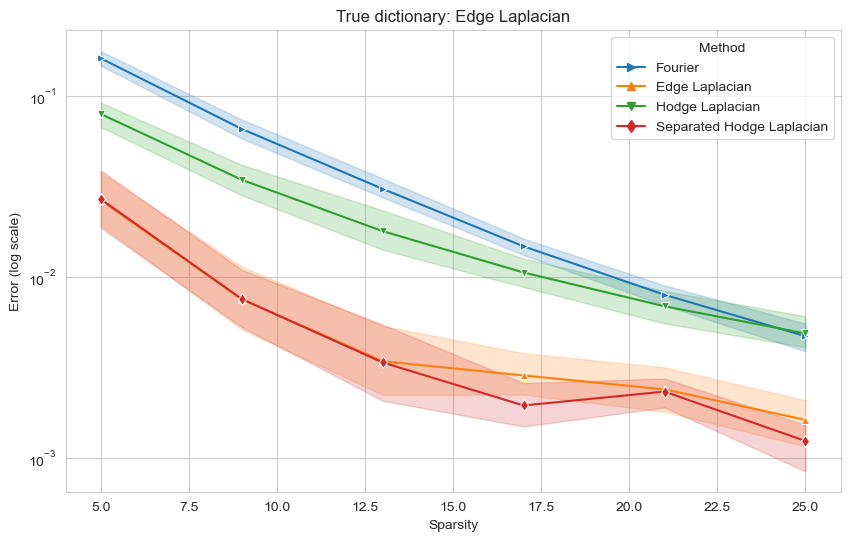

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

TITLE = "Edge Laplacian"

res_df = pd.DataFrame()
dict_types = {"fou": "Fourier", "edge": "Edge Laplacian", "joint": "Hodge Laplacian", "sep": "Separated Hodge Laplacian"}

for d in dict_types.items():
    for sim in range(6, n_sim):
        tmp_df = pd.DataFrame()   
        tmp_df["Error"] = eval(f'min_error_{d[0]}_test[sim,:]')
        tmp_df["Sparsity"] = K0_coll
        tmp_df["Method"] = d[1]
        res_df = pd.concat([res_df, tmp_df])

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
my_plt = sns.lineplot(data=res_df, x='Sparsity', y='Error', hue='Method',
                       palette=sns.color_palette(),
                       markers=['>', '^', 'v', 'd'], dashes=False, style='Method')
my_plt.set(yscale='log')
my_plt.set_title(f'True dictionary: {TITLE}')
my_plt.set_ylabel('Error (log scale)')
plt.show()

# Save variables and workspace

In [108]:
import pickle
import os
import dill

save_var = {"min_error_edge_test":min_error_edge_test,
            "min_error_edge_train":min_error_edge_train,
            "min_error_fou_test":min_error_fou_test,
            "min_error_fou_train":min_error_fou_train,
            "min_error_joint_test":min_error_joint_test,
            "min_error_joint_train":min_error_joint_train,
            "min_error_sep_test":min_error_sep_test,
            "min_error_sep_train":min_error_sep_train}

PATH = os.getcwd()
DIR_PATH = f'{PATH}\\results\\{dictionary_type}'
FILENAME_ERR = f'{DIR_PATH}\\error.pkl'
FILENAME_ENV = f'{DIR_PATH}\\ipynb_env.db'
FILENAME_PLT = f'{DIR_PATH}\\plot.png'

if not os.path.exists(DIR_PATH):
    os.makedirs(DIR_PATH)
    
with open(FILENAME_ERR, 'wb') as f: 
    pickle.dump(save_var, f)
f.close()

dill.dump_session(FILENAME_ENV)

fig = my_plt.get_figure()
fig.savefig(FILENAME_PLT)

# Vettorizzazione for esterni

In [935]:
# import scipy.io
# mat = scipy.io.loadmat('datiSC.mat')
# B1 = mat["B1"]
# B2 = mat["B2"]

# # Subsampling if needed to decrease complexity
# sub_size = 100
# B1 = B1[:, :sub_size]
# B2 = B2[:sub_size, :]
# B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# # Laplacians
# Ld = np.matmul(np.transpose(B1), B1, dtype=float)
# Lu = np.matmul(B2, np.transpose(B2), dtype=float)
# L = Lu+Ld
# n =  L.shape[0]
# nu = B2.shape[1]
# nd = B1.shape[1]
# _ ,U = la.eig(L)

# # Problem and Dictionary Dimensionalities
# dictionary_type_true = "separated"
# m_train = 150 # Number of Train Signals
# m_test = 80 # Number of Test Signal
# s_true = 3 # Number of Kernels (Sub-dictionaries)
# k_true = 2 # Polynomial order
# sparsity = .1 # Sparsity percentage
# K0_max = 20 #floor(n*sparsity) # Sparsity
# sparsity_mode = "max"

# # Data-Independent Problem Hyperparameters
# dictionary_type = dictionary_type_true
# s = s_true
# k = k_true
# K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
# lambda_ = 1e-6 # l2 multiplier
# max_iter = 100 # Maximum number of iterations
# patience = 5 # Patience
# tol = 1e-7 # Tolerance for Patience
# n_sim = 10
# verbose = 0
# # for sim in range(5,n_sim):
# tmp_res = pd.DataFrame()
# def vectorized_generation(Lu,Ld,m_train,m_test,s, K, K0, dictionary_type, sparsity_mode):
#     D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
#                                                                                 Ld,
#                                                                                 m_train,
#                                                                                 m_test, 
#                                                                                 s=s, 
#                                                                                 K=K, 
#                                                                                 K0=K0, 
#                                                                                 dictionary_type=dictionary_type, 
#                                                                                 sparsity_mode=sparsity_mode)
#     res_dict ={"D_try":D_try,
#             "h":h,
#             "Y_train_try":Y_train_try,
#             "Y_test_try":Y_test_try,
#             "epsilon_try":epsilon_try,
#             "c_try":c_try,
#             "X_train_try":X_train_try,
#             "X_test_try":X_test_try}
#     return res_dict

# def vectorized_verify(row, K0_max, acc_tresh):
#     D_try=row["D_try"]
#     Y_train_try=row["Y_train_try"]
#     X_train_try=row["X_train_try"]
#     max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, acc_tresh)
#     row["acc"] = acc
#     row["max_s"] = max_possible_sparsity
#     return row

# tmp_res["search"] = np.arange(3000)
# tmp_res["res_dict"] = tmp_res.search.apply(lambda row: vectorized_generation(Lu,Ld,m_train,m_test,s=s, K=k, K0=K0_max, dictionary_type=dictionary_type, sparsity_mode=sparsity_mode))
# tmp_res["res_dict"] = tmp_res.res_dict.apply(lambda row:  vectorized_verify(row, K0_max, 0.7))